# Assignment 4, by Maksim Kaledin

## Sub-problem 1

Let $b_j$ be the coordinate of $j$-th beacon, $w_i$ be the location of waypoint number $i$. Reconstruction problem could be formulated as LS problem with residuals $b_j-w_i-d_{ij}$, where $d_{ij}$ is the displacement of beacon $i$ w.r.to waypoint $i$. So we get the following minimization problem:

$$
\min_{\mathbf{w},\mathbf{b}} \sum_{i \in W} \sum_{j \in N(i)} \Vert b_j-w_i-d_{ij} \Vert,
$$

here $W$ denotes set of waypoints and $N(i)$ stands for "neigbourhood", the set of beacons sensed in waypoint $i$.

To solve this one way is to construct the normal equations, its solution will be an optimum since the goal function $F$ is convex.

$$
\begin{split}
\frac{\partial F}{\partial b_j}= \sum_{i \in W: j \in N(i)} 2(b_j-w_i-d_{ij}),\\
\frac{\partial F}{\partial w_i}= \sum_{j \in N(i)} -2(b_j-w_i-d_{ij})
\end{split}
$$

is a system of linear equations, so we construct the matrix $A$, right part $\mathbf{f}$, and solve

$$
A
\begin{bmatrix}
\mathbf{b}\\
\mathbf{w}
\end{bmatrix}=\mathbf{f}.
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def construct_linsyst(ws,bs,ds_x,ds_y):

    beacs_inds = np.sort(np.unique(bs))
    ws_inds = np.unique(ws)
    
    n=ws_inds.shape[0]
    m=beacs_inds.shape[0]
    
    A=np.zeros((2*(n+m),2*(n+m)))
    f=np.zeros((2*(n+m),1))
    #construct the first set of eqs vector is b_00 b_01, b_10 b_11 ,...
    for j in beacs_inds:
        j_ind = np.where(bs==j)
        w_ind = np.unique(ws[j_ind])
        A[2*(j-1),2*(m+w_ind-1)]=-1 #set coef before w_i
        A[2*(j-1)+1,2*(m+w_ind-1)+1]=-1
        
        A[2*(j-1),2*(j-1)]=w_ind.shape[0]
        A[2*(j-1)+1,2*(j-1)+1]=w_ind.shape[0]
        
        f[2*(j-1)]=np.sum(ds_x[j_ind])
        f[2*(j-1)+1]=np.sum(ds_y[j_ind])
        
    #the second one
    for i in ws_inds:
        b_ind=np.unique(bs[np.where(ws==i)])
        
        A[2*m+2*(i-1),2*(b_ind-1)]=1#set coef before b_i
        A[2*m+2*(i-1)+1,2*(b_ind-1)+1]=1
        
        A[2*m+2*(i-1),2*m+2*(i-1)]=-b_ind.shape[0]
        A[2*m+2*(i-1)+1,2*m+2*(i-1)+1]=-b_ind.shape[0]
        
        w_ind=np.where(ws==i)
        f[2*m+2*(i-1)]=np.sum(ds_x[w_ind])
        f[2*m+2*(i-1)+1]=np.sum(ds_y[w_ind])
        
    return (A,f)



In [9]:
import scipy.io as sio

task1_contents = sio.loadmat('task1.mat')

beacs_1 = task1_contents['beacons']
robots_1 = task1_contents['robots']
x_1 = task1_contents['x']
y_1 = task1_contents['y']

n=np.unique(robots_1).shape[0]
m=np.unique(beacs_1).shape[0]

    
(A,f) = construct_linsyst(robots_1,beacs_1,x_1,y_1)


In [10]:
import scipy.linalg as splin

sol = splin.solve(A,f)

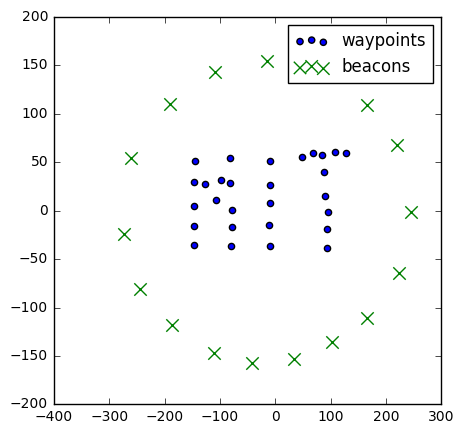

In [16]:
waypoints_x = np.array(sol[np.arange(2*m,2*m+2*n,2),0])
waypoints_y = np.array(sol[np.arange(2*m+1,2*m+2*n,2),0])

#print(waypoints_x,waypoints_y)
beacons_x = np.array(sol[np.arange(0,2*m,2),0])
beacons_y = np.array(sol[np.arange(1,2*m,2),0])
#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])